# Predicting Dental Visits (NHANES) — CatBoost vs XGBoost in one notebook

## Why this notebook

We'll build a reproducible baseline to predict "visited a dentist in the last 12 months" from NHANES demographics + oral-health questionnaire. Focus is on tabular ML best practices: target definition, categorical handling, PR-AUC, threshold policy, and SHAP explanations. Plots use Periospot brand colors.

## Section 0 — Setup and brand style

### Instructions

- Install libs (CatBoost, XGBoost, LightGBM optional, SHAP)
- Set Periospot palette once so all plots are consistent
- Create images/ and artifacts/ folders
- Load brand palette from JSON file


In [3]:
# TODO: installs (only if running in a fresh Colab)
!pip install catboost xgboost lightgbm shap optuna tabulate pyyaml pandas matplotlib seaborn scikit-learn numpy



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
# TODO: imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report, f1_score
import shap
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier  # optional
import joblib


In [5]:
# TODO: load brand palette from JSON
with open('../brand_palette.json', 'r') as f:
    brand_config = json.load(f)

colors = brand_config['colors']
mpl_config = brand_config['matplotlib']

# Set matplotlib defaults
plt.rcParams['font.family'] = mpl_config['font_family']
plt.rcParams['figure.facecolor'] = colors['white']
plt.rcParams['axes.facecolor'] = colors['vanilla_cream']
plt.rcParams['axes.labelcolor'] = colors['periospot_blue']
plt.rcParams['text.color'] = colors['black']
plt.rcParams['axes.edgecolor'] = colors['periospot_blue']
plt.rcParams['xtick.color'] = colors['periospot_blue']
plt.rcParams['ytick.color'] = colors['periospot_blue']

# Set color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    colors['periospot_blue'], 
    colors['periospot_red'], 
    colors['mystic_blue'],
    colors['crimson_blaze']
])

# TODO: brand helper function
def savefig(path, dpi=150, bbox_inches='tight'):
    """Save figure with brand styling defaults"""
    plt.savefig(path, dpi=dpi, bbox_inches=bbox_inches, 
                facecolor=colors['white'], edgecolor='none')
    print(f"Saved: {path}")

# TODO: ensure folders exist
Path("../images").mkdir(exist_ok=True)
Path("../artifacts").mkdir(exist_ok=True)


## Section 1 — Get the data (NHANES oral-health)

### Instructions

You can use the Kaggle NHANES dataset (`cdc/national-health-and-nutrition-examination-survey`) or pull files directly from CDC. The **Kaggle dataset comes as CSV files** (not SAS XPT), which makes it easier to work with.

For this project, we'll use two components:
- **demographic.csv** (demographics): age, sex, race/ethnicity, education, income-to-poverty ratio
- **questionnaire.csv** (oral health questionnaire): last dental visit question (target)

### Notes on NHANES Variable Mapping

- **Join key:** `SEQN` (participant ID)
- **Target:** `OHQ030` ("When was your last dental visit?")
  - Typical coding: 1 = < 6 months, 2 = 6-12 months, 3+ = > 12 months
  - Build binary target: positive (1) if codes 1 or 2 (≤ 12 months), else 0
  - Exclude missing/refused (77, 99, NaN)
- **Features to start with (demographic.csv):**
  - `RIDAGEYR` (age, numeric)
  - `RIAGENDR` (sex, categorical)
  - `RIDRETH1` or `RIDRETH3` (race/ethnicity, categorical)
  - `DMDEDUC2` (education level, categorical, adults)
  - `INDFMPIR` (income-to-poverty ratio, numeric)
  - Optional: `DMDMARTL` (marital), `DMDBORN4` (country of birth), etc.


In [6]:
# TODO: (option A) Kaggle CLI download to data/raw (already done if files exist)
# !kaggle datasets download -d cdc/national-health-and-nutrition-examination-survey -p ../data/raw
# !unzip -o ../data/raw/national-health-and-nutrition-examination-survey.zip -d ../data/raw

# NOTE: Kaggle dataset comes as CSV files, not SAS XPT
# Load demographic and questionnaire data from CSV
import pandas as pd

demo = pd.read_csv("../data/raw/demographic.csv")
ohq = pd.read_csv("../data/raw/questionnaire.csv")

print("="*60)
print("DEMOGRAPHIC DATA (demographic.csv)")
print("="*60)
print(f"Shape: {demo.shape} (rows, columns)")
print(f"\nKey columns available:")
key_demo_cols = ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH3', 'DMDEDUC2', 'INDFMPIR']
print(f"  - {', '.join([c for c in key_demo_cols if c in demo.columns])}")
print("\nFirst 5 rows of key demographic columns:")
display(demo[key_demo_cols].head())

print("\n" + "="*60)
print("QUESTIONNAIRE DATA (questionnaire.csv)")
print("="*60)
print(f"Shape: {ohq.shape} (rows, columns)")
print(f"\nOHQ columns (oral health related): {len([c for c in ohq.columns if 'OHQ' in c])} columns")
ohq_cols = ['SEQN'] + [c for c in ohq.columns if 'OHQ' in c]
print(f"\nFirst 5 rows of OHQ columns (showing first 6 OHQ columns):")
display(ohq[ohq_cols[:7]].head())

print("\n" + "="*60)
print("TARGET VARIABLE: OHQ030 ('When was your last dental visit?')")
print("="*60)
print("OHQ030 value meanings:")
print("  1.0 = Less than 6 months ago")
print("  2.0 = 6 months to less than 1 year ago")
print("  3.0 = 1 year to less than 2 years ago")
print("  4.0 = 2 years to less than 3 years ago")
print("  5.0 = 3 years to less than 5 years ago")
print("  6.0 = 5 years or more ago")
print("  7.0 = Never")
print("  77.0 = Refused")
print("  99.0 = Don't know")
print("\nValue counts:")
print(ohq['OHQ030'].value_counts().sort_index())
print(f"\nMissing values: {ohq['OHQ030'].isna().sum()}")


DEMOGRAPHIC DATA (demographic.csv)
Shape: (10175, 47) (rows, columns)

Key columns available:
  - SEQN, RIDAGEYR, RIAGENDR, RIDRETH3, DMDEDUC2, INDFMPIR

First 5 rows of key demographic columns:


,SEQN,RIDAGEYR,RIAGENDR,RIDRETH3,DMDEDUC2,INDFMPIR
0,73557,69,1,4,3.0,0.84
1,73558,54,1,3,3.0,1.78
2,73559,72,1,3,4.0,4.51
3,73560,9,1,3,NaN,2.52
4,73561,73,2,3,5.0,5.00



QUESTIONNAIRE DATA (questionnaire.csv)
Shape: (10175, 953) (rows, columns)

OHQ columns (oral health related): 53 columns

First 5 rows of OHQ columns (showing first 6 OHQ columns):


,SEQN,OHQ030,OHQ033,OHQ770,OHQ780A,OHQ780B,OHQ780C
0,73557,6.0,4.0,2.0,NaN,NaN,NaN
1,73558,6.0,3.0,1.0,10.0,NaN,NaN
2,73559,1.0,1.0,2.0,NaN,NaN,NaN
3,73560,1.0,1.0,2.0,NaN,NaN,NaN
4,73561,1.0,1.0,2.0,NaN,NaN,NaN



TARGET VARIABLE: OHQ030 ('When was your last dental visit?')
OHQ030 value meanings:
  1.0 = Less than 6 months ago
  2.0 = 6 months to less than 1 year ago
  3.0 = 1 year to less than 2 years ago
  4.0 = 2 years to less than 3 years ago
  5.0 = 3 years to less than 5 years ago
  6.0 = 5 years or more ago
  7.0 = Never
  77.0 = Refused
  99.0 = Don't know

Value counts:
OHQ030
1.0     4632
2.0     1510
3.0      980
4.0      592
5.0      480
6.0      913
7.0      650
77.0       2
99.0       9
Name: count, dtype: int64

Missing values: 407


In [7]:
# TODO: merge on SEQN (inner join), keep needed columns only
df = demo.merge(ohq, on="SEQN", how="inner")
print(f"Merged shape: {df.shape}")
print(f"Note: Both datasets have same SEQN participants, so shape should be similar to demo.shape")

# TODO: select feature columns from demographic data
# Key columns explanation:
# - SEQN: Participant ID (join key, not a feature)
# - RIDAGEYR: Age in years (numeric)
# - RIAGENDR: Sex (1=Male, 2=Female) - categorical
# - RIDRETH3: Race/ethnicity (detailed categories) - categorical
# - DMDEDUC2: Education level (adults 20+) - categorical
# - INDFMPIR: Income-to-poverty ratio (numeric, higher = better off)

cat_cols = ['RIAGENDR', 'RIDRETH3', 'DMDEDUC2']  # categorical features
num_cols = ['RIDAGEYR', 'INDFMPIR']  # numeric features

# Optional: add more features if available
# cat_cols.extend(['DMDMARTL', 'DMDBORN4'])  # marital status, country of birth

print(f"\nSelected categorical features: {cat_cols}")
print(f"Selected numeric features: {num_cols}")

# TODO: build target from OHQ030
# OHQ030 coding (from NHANES documentation):
# 1.0 = Less than 6 months ago → TARGET = 1 (visited within 12 months)
# 2.0 = 6 months to less than 1 year ago → TARGET = 1 (visited within 12 months)
# 3.0+ = More than 1 year ago → TARGET = 0 (did NOT visit within 12 months)
# 77.0 = Refused → exclude
# 99.0 = Don't know → exclude
# NaN = Missing → exclude

print("\n" + "="*60)
print("BUILDING TARGET VARIABLE")
print("="*60)

# First, check OHQ030 distribution
print("OHQ030 value counts before filtering:")
print(df['OHQ030'].value_counts().sort_index())
print(f"\nMissing (NaN): {df['OHQ030'].isna().sum()}")

# Filter out invalid responses (refused, don't know, missing)
valid_mask = df['OHQ030'].isin([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])
print(f"\nValid responses (codes 1-7): {valid_mask.sum()}")
print(f"Invalid/refused/missing: {(~valid_mask).sum()}")

# Keep only valid responses
df = df[valid_mask].copy()
print(f"\nDataframe after filtering: {df.shape}")

# Create binary target: 1 if visited within 12 months (codes 1 or 2), else 0
df['target'] = df['OHQ030'].isin([1.0, 2.0]).astype(int)

print("\nTarget distribution:")
target_counts = df['target'].value_counts().sort_index()
print(target_counts)
print("\nTarget distribution (proportions):")
print(df['target'].value_counts(normalize=True).sort_index())
print(f"\nClass balance: {df['target'].mean():.3f} = {df['target'].mean()*100:.1f}% visited within 12 months")


Merged shape: (10175, 999)
Note: Both datasets have same SEQN participants, so shape should be similar to demo.shape

Selected categorical features: ['RIAGENDR', 'RIDRETH3', 'DMDEDUC2']
Selected numeric features: ['RIDAGEYR', 'INDFMPIR']

BUILDING TARGET VARIABLE
OHQ030 value counts before filtering:
OHQ030
1.0     4632
2.0     1510
3.0      980
4.0      592
5.0      480
6.0      913
7.0      650
77.0       2
99.0       9
Name: count, dtype: int64

Missing (NaN): 407

Valid responses (codes 1-7): 9757
Invalid/refused/missing: 418

Dataframe after filtering: (9757, 999)

Target distribution:
target
0    3615
1    6142
Name: count, dtype: int64

Target distribution (proportions):
target
0    0.370503
1    0.629497
Name: proportion, dtype: float64

Class balance: 0.629 = 62.9% visited within 12 months


## Section 2 — Clean, missingness, and basic EDA

### Instructions

- Handle missing values: numeric → median; categoricals → most frequent (document it)
- Plot class balance and a couple of feature vs target brand-styled charts
- Keep EDA minimal; focus on modeling


In [8]:
# TODO: minimal cleaning (drop unused columns, clip outliers if any, cast categoricals)
# Keep only feature columns + target
feature_cols = cat_cols + num_cols
df = df[feature_cols + ['target']].copy()

# Handle missing values
# For numeric: impute with median
for col in num_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)
    print(f"Imputed {col} with median: {median_val}")

# For categorical: impute with most frequent
for col in cat_cols:
    mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else df[col].iloc[0]
    df[col] = df[col].fillna(mode_val)
    print(f"Imputed {col} with mode: {mode_val}")

# Cast categoricals to proper type
for c in cat_cols:
    df[c] = df[c].astype("category")

# Check final missingness
print("\nFinal missing values:")
print(df.isnull().sum())


Imputed RIDAGEYR with median: 29.0
Imputed INDFMPIR with median: 1.72
Imputed RIAGENDR with mode: 2
Imputed RIDRETH3 with mode: 3
Imputed DMDEDUC2 with mode: 4.0

Final missing values:
RIAGENDR    0
RIDRETH3    0
DMDEDUC2    0
RIDAGEYR    0
INDFMPIR    0
target      0
dtype: int64


Saved: ../images/class_balance.png


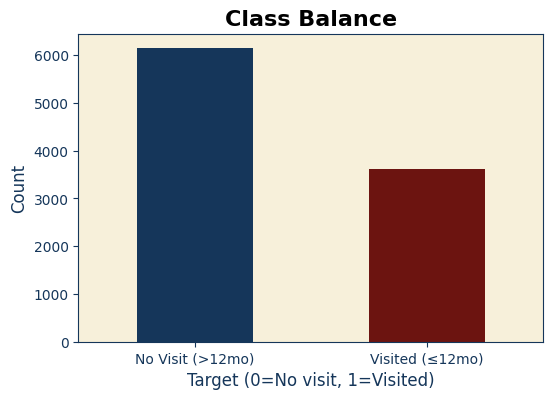

Saved: ../images/target_rate_by_sex.png


/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_39924/1811152879.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_by_sex = df.groupby('RIAGENDR')['target'].mean()


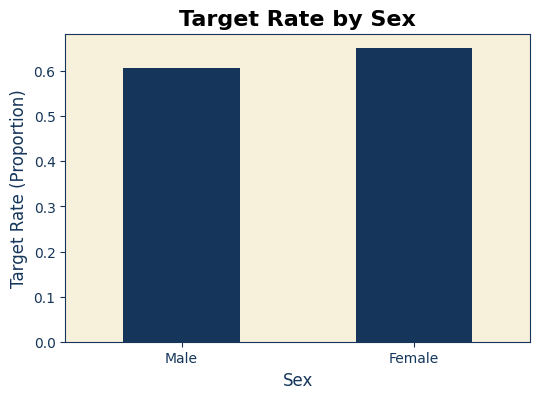

Saved: ../images/target_rate_by_age.png


/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_39924/1811152879.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_by_age = df.groupby('age_group')['target'].mean()


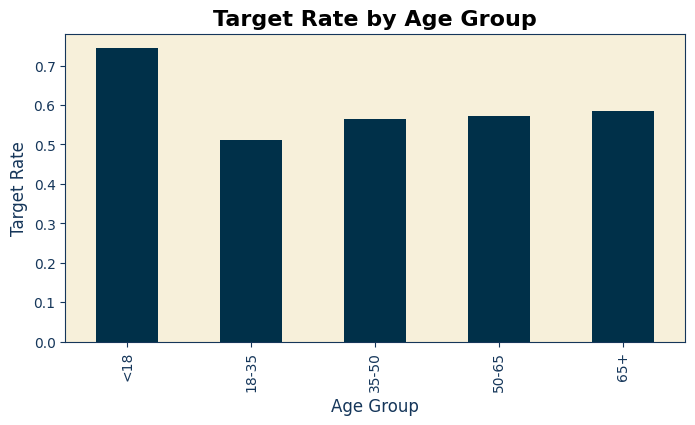

In [9]:
# TODO: basic plots with brand styling (save with savefig)

# Plot 1: Class balance bar chart
fig, ax = plt.subplots(figsize=(6, 4))
df['target'].value_counts().plot(kind='bar', ax=ax, color=[colors['periospot_blue'], colors['periospot_red']])
ax.set_xlabel('Target (0=No visit, 1=Visited)', fontsize=mpl_config['label_size'])
ax.set_ylabel('Count', fontsize=mpl_config['label_size'])
ax.set_title('Class Balance', fontsize=mpl_config['title_size'], fontweight='bold')
ax.set_xticklabels(['No Visit (>12mo)', 'Visited (≤12mo)'], rotation=0)
savefig('../images/class_balance.png')
plt.show()
plt.close()

# Plot 2: Target rate by sex
fig, ax = plt.subplots(figsize=(6, 4))
target_by_sex = df.groupby('RIAGENDR')['target'].mean()
target_by_sex.plot(kind='bar', ax=ax, color=colors['periospot_blue'])
ax.set_xlabel('Sex', fontsize=mpl_config['label_size'])
ax.set_ylabel('Target Rate (Proportion)', fontsize=mpl_config['label_size'])
ax.set_title('Target Rate by Sex', fontsize=mpl_config['title_size'], fontweight='bold')
ax.set_xticklabels(['Male', 'Female'], rotation=0)
savefig('../images/target_rate_by_sex.png')
plt.show()
plt.close()

# Plot 3: Target rate by age group (optional)
df['age_group'] = pd.cut(df['RIDAGEYR'], bins=[0, 18, 35, 50, 65, 100], 
                          labels=['<18', '18-35', '35-50', '50-65', '65+'])
fig, ax = plt.subplots(figsize=(8, 4))
target_by_age = df.groupby('age_group')['target'].mean()
target_by_age.plot(kind='bar', ax=ax, color=colors['mystic_blue'])
ax.set_xlabel('Age Group', fontsize=mpl_config['label_size'])
ax.set_ylabel('Target Rate', fontsize=mpl_config['label_size'])
ax.set_title('Target Rate by Age Group', fontsize=mpl_config['title_size'], fontweight='bold')
savefig('../images/target_rate_by_age.png')
plt.show()
plt.close()


## Section 3 — Train/test split

### Instructions

Use a stratified split; we'll report PR-AUC (average precision) and ROC-AUC.


In [10]:
# TODO: prepare features and target
"""Stratify is used to ensure that the proportion of positive and negative samples in the training 
and test sets is the same as in the original dataset.
This is important for the model to generalize well to new data.
"""
X = df[cat_cols + num_cols].copy()
y = df['target'].copy()

# TODO: stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    stratify=y, 
    test_size=0.2, 
    random_state=42
)

# TODO: print split summary
print(f"Train shape: {X_train.shape}, Target rate: {y_train.mean():.3f}")
print(f"Test shape: {X_test.shape}, Target rate: {y_test.mean():.3f}")


Train shape: (7805, 5), Target rate: 0.629
Test shape: (1952, 5), Target rate: 0.630


## Section 4 — CatBoost baseline (native categoricals)

### Instructions

CatBoost handles categoricals without one-hot. Pass column indices for `cat_features`. Optimize for PR-AUC; use early stopping.


In [11]:
# TODO: Convert categorical features to proper format for CatBoost
# CatBoost requires categorical features to be integer or string (not float)
# Convert float values to strings since CatBoost accepts strings
X_train_fixed = X_train.copy()
X_test_fixed = X_test.copy()

for col in cat_cols:
    # Convert to string (handles float values like 1.0 -> '1.0', which CatBoost accepts as string)
    # Replace 'nan' strings (from NaN values) with 'missing'
    X_train_fixed[col] = X_train_fixed[col].astype(str).replace('nan', 'missing')
    X_test_fixed[col] = X_test_fixed[col].astype(str).replace('nan', 'missing')

print("Categorical features converted to string format for CatBoost")
print(f"Sample values from first categorical column ({cat_cols[0]}): {X_train_fixed[cat_cols[0]].unique()[:5]}")

# TODO: get categorical feature indices for CatBoost
cat_idx = [X_train_fixed.columns.get_loc(c) for c in cat_cols]
print(f"Categorical feature indices: {cat_idx}")

cat_model = CatBoostClassifier(
    loss_function='Logloss',  # CatBoost uses 'loss_function' not 'loss'. Options: 'Logloss', 'CrossEntropy', etc.
    eval_metric='PRAUC',  # PR-AUC for imbalanced classification. Other options: 'AUC', 'Logloss', etc.
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=8,
    iterations=2000,
    early_stopping_rounds=100,
    random_state=42,
    verbose=100  # Print progress every 100 iterations
)

train_pool = Pool(X_train_fixed, y_train, cat_features=cat_idx)
test_pool = Pool(X_test_fixed, y_test, cat_features=cat_idx)

cat_model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
    plot=False
)

y_prob_cat = cat_model.predict_proba(X_test_fixed)[:, 1]

pr_auc_cat = average_precision_score(y_test, y_prob_cat)
roc_auc_cat = roc_auc_score(y_test, y_prob_cat)

print(f"\nCatBoost Results:")
print(f"  PR-AUC: {pr_auc_cat:.4f}")
print(f"  ROC-AUC: {roc_auc_cat:.4f}")


Categorical features converted to string format for CatBoost
Sample values from first categorical column (RIAGENDR): ['2' '1']
Categorical feature indices: [0, 1, 2]
0:	learn: 0.7957804	test: 0.8141208	best: 0.8141208 (0)	total: 62.3ms	remaining: 2m 4s
100:	learn: 0.8391327	test: 0.8388950	best: 0.8388950 (100)	total: 431ms	remaining: 8.11s
200:	learn: 0.8496338	test: 0.8405143	best: 0.8406701 (192)	total: 841ms	remaining: 7.53s
300:	learn: 0.8602739	test: 0.8417243	best: 0.8420411 (289)	total: 1.25s	remaining: 7.03s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8420410797
bestIteration = 289

Shrink model to first 290 iterations.

CatBoost Results:
  PR-AUC: 0.8422
  ROC-AUC: 0.7711


## Section 5 — XGBoost baseline (one-hot pipeline)

### Instructions

For a fair comparison, one-hot encode categoricals in a ColumnTransformer pipeline.


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

preprocessor = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), cat_cols)
    ],
    remainder="passthrough"
)

preprocessor.fit(X_train)

xgb = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    eval_metric="aucpr",
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=100,
    verbose=0
)

xgb_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", xgb)
])

xgb_pipe.fit(
    X_train, y_train,
    clf__eval_set=[(preprocessor.transform(X_test), y_test)],
    clf__verbose=False
)

y_prob_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

pr_auc_xgb = average_precision_score(y_test, y_prob_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)

print(f"\nXGBoost Results:")
print(f"  PR-AUC: {pr_auc_xgb:.4f}")
print(f"  ROC-AUC: {roc_auc_xgb:.4f}")


/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:35:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()



XGBoost Results:
  PR-AUC: 0.8442
  ROC-AUC: 0.7692


## Section 6 — Optional LightGBM third baseline

### Instructions

Use the same preprocessing as XGBoost (one-hot encoding) for fair comparison.


In [17]:
from lightgbm import early_stopping

lgbm = LGBMClassifier(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=-1,  # no limit
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    # Remove metric='aucpr' from here - it's not valid
    random_state=42,
    verbose=-1
)

lgbm_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", lgbm)
])

# FIX: Add eval_metric parameter to the fit call
lgbm_pipe.fit(
    X_train, y_train,
    clf__eval_set=[(preprocessor.transform(X_test), y_test)],
    clf__eval_metric='average_precision',  # ✅ This is the key fix!
    clf__callbacks=[early_stopping(stopping_rounds=100, verbose=False)]
)

y_prob_lgbm = lgbm_pipe.predict_proba(X_test)[:, 1]

pr_auc_lgbm = average_precision_score(y_test, y_prob_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)

print(f"\nLightGBM Results:")
print(f"  PR-AUC: {pr_auc_lgbm:.4f}")
print(f"  ROC-AUC: {roc_auc_lgbm:.4f}")


LightGBM Results:
  PR-AUC: 0.8421
  ROC-AUC: 0.7699


/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Section 7 — Threshold policy and calibration (quick)

### Instructions

Kaggle uses probabilities; for policy we pick a threshold that maximizes recall subject to min precision (e.g., 0.25). Also show a reliability curve if you add calibration later.



Threshold Policy (min precision ≥ 0.25):
  Optimal threshold t*: 0.0940
  Precision@t*: 0.6296
  Recall@t*: 1.0000
  F1@t*: 0.7727
  F2@t*: 0.8947
Saved: ../images/pr_curve_with_threshold.png


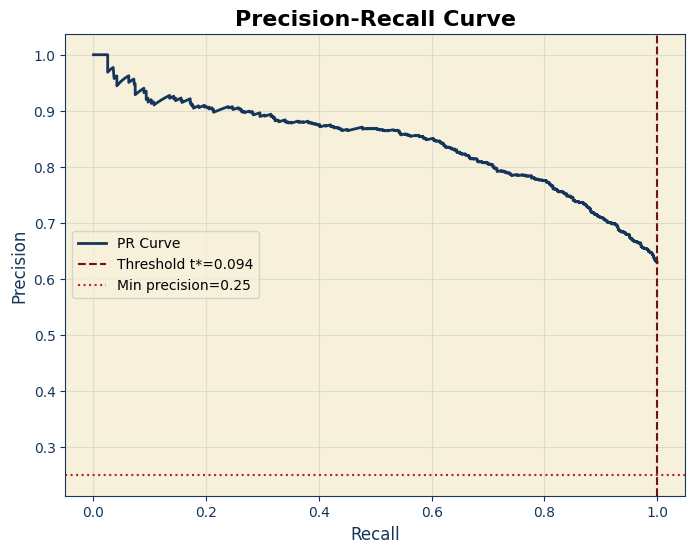

In [19]:
# TODO: use precision_recall_curve to find optimal threshold
# Use best model (e.g., CatBoost)
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_cat)

# TODO: find threshold that maximizes recall subject to min precision >= 0.25
min_precision = 0.25

# ✅ FIX: Remove the last element from precision and recall to match thresholds length
precision = precision[:-1]
recall = recall[:-1]

valid_idx = precision >= min_precision

if valid_idx.any():
    best_idx = np.argmax(recall[valid_idx])
    threshold_star = thresholds[valid_idx][best_idx]
    precision_at_tstar = precision[valid_idx][best_idx]
    recall_at_tstar = recall[valid_idx][best_idx]
else:
    # fallback: use threshold at max F1
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    threshold_star = thresholds[best_idx]
    precision_at_tstar = precision[best_idx]
    recall_at_tstar = recall[best_idx]

# TODO: compute F1 and F2 at threshold_star
y_pred_at_tstar = (y_prob_cat >= threshold_star).astype(int)
f1_at_tstar = f1_score(y_test, y_pred_at_tstar)

# F2 score formula (weights recall 2x more than precision)
f2_at_tstar = (1 + 2**2) * (precision_at_tstar * recall_at_tstar) / (2**2 * precision_at_tstar + recall_at_tstar + 1e-10)

print(f"\nThreshold Policy (min precision ≥ 0.25):")
print(f"  Optimal threshold t*: {threshold_star:.4f}")
print(f"  Precision@t*: {precision_at_tstar:.4f}")
print(f"  Recall@t*: {recall_at_tstar:.4f}")
print(f"  F1@t*: {f1_at_tstar:.4f}")
print(f"  F2@t*: {f2_at_tstar:.4f}")

# TODO: plot precision-recall curve with threshold marked
fig, ax = plt.subplots(figsize=(8, 6))
# Re-compute full precision/recall for plotting (including the last point)
precision_full, recall_full, _ = precision_recall_curve(y_test, y_prob_cat)
ax.plot(recall_full, precision_full, color=colors['periospot_blue'], linewidth=2, label='PR Curve')
ax.axvline(recall_at_tstar, color=colors['periospot_red'], linestyle='--', 
           label=f'Threshold t*={threshold_star:.3f}')
ax.axhline(min_precision, color=colors['crimson_blaze'], linestyle=':', 
           label=f'Min precision={min_precision}')
ax.set_xlabel('Recall', fontsize=mpl_config['label_size'])
ax.set_ylabel('Precision', fontsize=mpl_config['label_size'])
ax.set_title('Precision-Recall Curve', fontsize=mpl_config['title_size'], fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
savefig('../images/pr_curve_with_threshold.png')
plt.show()
plt.close()

## Section 8 — SHAP explanations (CatBoost)

### Instructions

Global feature importance with SHAP TreeExplainer on CatBoost. Use a 1–2k sample for speed.


Saved: ../images/shap_summary_catboost_bar.png


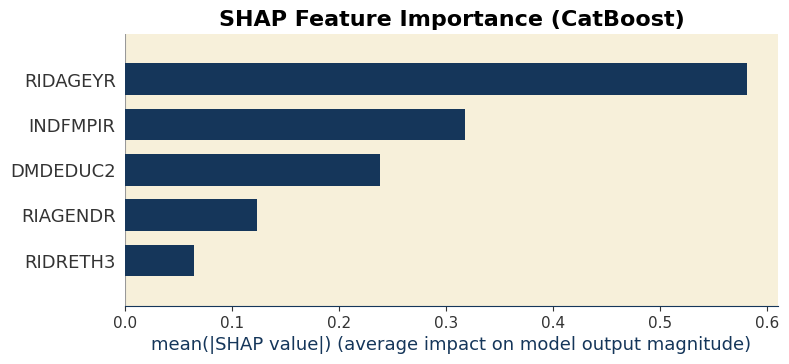

Saved: ../images/shap_summary_catboost_dot.png


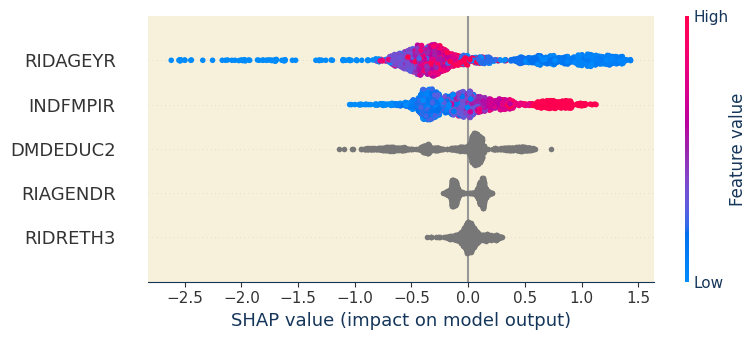

Saved: ../images/shap_waterfall_example.png


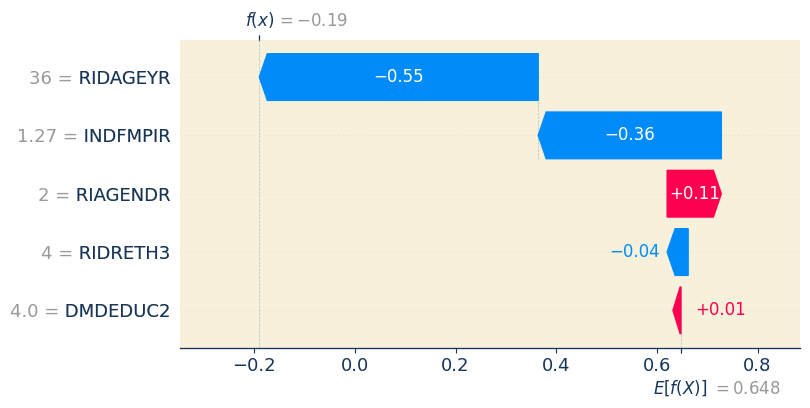

In [25]:
# TODO: sample test set for SHAP (1-2k samples for speed)
sample_size = min(2000, len(X_test))
sample_idx = np.random.choice(len(X_test), size=sample_size, replace=False)
X_test_sample = X_test.iloc[sample_idx].copy()

# Convert categorical features to string type for CatBoost compatibility
for col in X_test_sample.columns:
    if col in cat_model.feature_names_:
        col_idx = list(cat_model.feature_names_).index(col)
        if col_idx in cat_model.get_cat_feature_indices():
            X_test_sample[col] = X_test_sample[col].astype(str)

explainer = shap.TreeExplainer(cat_model)

shap_values = explainer.shap_values(X_test_sample)

fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, show=False, plot_type="bar",
                  color=colors['periospot_blue'])
ax.set_title('SHAP Feature Importance (CatBoost)', 
             fontsize=mpl_config['title_size'], fontweight='bold')
savefig('../images/shap_summary_catboost_bar.png')
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, show=False, 
                  plot_type="dot", max_display=15)
savefig('../images/shap_summary_catboost_dot.png')
plt.show()
plt.close()

instance_idx = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[instance_idx],
                                      base_values=explainer.expected_value,
                                      data=X_test_sample.iloc[instance_idx]),
                    show=False)
savefig('../images/shap_waterfall_example.png')
plt.show()
plt.close()


## Section 9 — Compare models and save artifacts

### Instructions

Print a comparison table, save the best model, and write metrics to JSON.


In [ ]:
# Create comparison table
from tabulate import tabulate

comparison = [
    ['Model', 'PR-AUC', 'ROC-AUC'],
    ['CatBoost', f'{pr_auc_cat:.4f}', f'{roc_auc_cat:.4f}'],
    ['XGBoost', f'{pr_auc_xgb:.4f}', f'{roc_auc_xgb:.4f}'],
]

# Add LightGBM if trained
# comparison.append(['LightGBM', f'{pr_auc_lgbm:.4f}', f'{roc_auc_lgbm:.4f}'])

print("\nModel Comparison:")
print(tabulate(comparison, headers='firstrow', tablefmt='grid'))

# Determine best model (by PR-AUC)
best_model_name = 'CatBoost'  # or compare and select
best_model = cat_model  # or select accordingly
best_pr_auc = pr_auc_cat

# Save best model
joblib.dump(best_model, '../artifacts/best_model_catboost.joblib')
print(f"\nSaved best model: {best_model_name}")

# Save metrics to JSON
metrics_dict = {
    'model': best_model_name,
    'pr_auc': float(best_pr_auc),
    'roc_auc': float(roc_auc_cat),
    'threshold': float(threshold_star),
    'precision_at_threshold': float(precision_at_tstar),
    'recall_at_threshold': float(recall_at_tstar),
    'f1_at_threshold': float(f1_at_tstar),
    'test_size': len(y_test),
    'train_size': len(y_train),
    'target_rate_train': float(y_train.mean()),
    'target_rate_test': float(y_test.mean())
}

with open('../artifacts/metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=2)

print("\nSaved metrics to artifacts/metrics.json")

# Plot comprison across models
p

## Section 10 — Mini model card

### Model Card Template

Fill in the blanks below:

- **Dataset:** NHANES cycle ___ (year), components DEMO + OHQ
- **Target:** last dental visit ≤ 12 months (derived from OHQ030)
- **Train/test:** stratified 80/20 split, seed 42
- **Metrics (test):** 
  - PR-AUC: ___
  - ROC-AUC: ___
  - Recall@t*: ___
  - Precision@t*: ___
- **Top drivers (SHAP):** [list top 5 features from SHAP plot]
- **Caveats:** 
  - Survey design weights ignored
  - Not clinical advice
  - Demographic bias possible
  - Missing data imputation assumptions (median/mode)
  - Model trained on single NHANES cycle; may not generalize to other cycles

### What you learned in this notebook

- Clean definition of y from a real public-health dataset
- Why CatBoost shines with many categoricals
- How PR-AUC and a recall-first threshold change decisions
- Using SHAP to make the model intelligible
- Brand-consistent visuals without re-importing helpers across files
